# Loop Hydrodynamics
Configure loop hydrodynamics with HYDRAD. We need to write an interface to the HYDRAD model that can both configure the simulations and load the results back in

In [9]:
import sys
import glob

import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import astropy.units as u
import astropy.constants as const
from astropy.utils.console import ProgressBar
import sunpy.sun.constants as sun_const
from scipy.interpolate import splrep,splev
from IPython.display import HTML

from hydrad_tools.configure import Configure
from hydrad_tools.parse import Strand
from hydrad_tools.visualize import plot_strand,animate_strand

import synthesizAR
from synthesizAR.interfaces.ebtel import power_law_transform,calculate_free_energy
from hydrad_interface import HYDRADInterface

from make_uniform_grid import interpolate_to_uniform_grid,save_to_hdf5
from hydrad_interface import HYDRADInterface

%matplotlib inline

Restore the field

In [14]:
active_region = synthesizAR.Field.restore('/storage-home/w/wtb2/data/hi_c_simulation/noaa12712_base/')

## Loading the Simulation Data
We have configured and run the results on the davinci and nots Rice clusters and downloaded the data to nikola. 

The data have been reduced to 1 HDF5 file per run with the electron temperature, ion temperature, density, velocity, time, and coordinate all saved as separate datasets. Rather than rebuild a new file with all of these results, each loop will have a separate savefile

Now, instantiate the interface for HYDRAD. We can use a dummy configuration and paths because we don't need to actually configure anything.

In [3]:
interface = HYDRADInterface({}, '', '')

Two primary things to do when loading in the data:

1. set the parameters savefile for each loop to the uniform grid HDF5 file
2. reinterpolate the Loop coordinates to the simulation resolution

Then, we need to save the field with the new interpolated loops.

In [12]:
parameter_savefile = '/storage-home/w/wtb2/data/hi_c_simulation/hydrodynamics/reduced_results/{}_uniform.h5'

In [ ]:
for loop in active_region.loops:
    # Assign parameter filename
    loop.parameter_
    # Interpolate loop coordinates
    # Interpolate field strengths

In [5]:
# Bound indices
i_start = 4000
i_finish = 6000
i_step = 2
# Read data
with PdfPages('bad_loops_report.pdf') as pdf:
    with ProgressBar(len(active_region.loops[::100]), ipython_widget=True,) as prog:
        for i,l in enumerate(active_region.loops[::100]):
            with h5py.File(parameter_savefile.format(l.name),'r') as hf:
                s = u.Quantity(hf['coordinate'],hf['coordinate'].attrs['unit'])
                t = u.Quantity(hf['time'][i_start:i_finish:i_step],hf['time'].attrs['unit'])
                Te = u.Quantity(hf['electron_temperature'][:,i_start:i_finish:i_step],
                                hf['electron_temperature'].attrs['unit'])
                n = u.Quantity(hf['density'][:,i_start:i_finish:i_step],hf['density'].attrs['unit'])
                v = u.Quantity(hf['velocity'][:,i_start:i_finish:i_step],hf['velocity'].attrs['unit'])
            # Create grids
            grid_s,grid_t = np.meshgrid(t.value,s.value)
            # Create plots
            # Electron temperature
            fig = plt.figure(figsize=(15,8),)
            ax = fig.add_subplot(3,1,1)
            ax.set_ylabel(r'$T_e$ [K]')
            ax.set_title(f'{l.name} $L={l.full_length.to(u.Mm):.2f}$')
            im = ax.pcolormesh(grid_s, grid_t, Te,cmap='plasma',vmin=5e5,vmax=8e6)
            im.set_rasterized(True)
            fig.colorbar(im,ax=ax)
            ## Density
            ax = fig.add_subplot(3,1,2)
            ax.set_ylabel(r'$n$ [cm$^{-3}$]')
            im = ax.pcolormesh(grid_s, grid_t, n,cmap='plasma_r',norm=matplotlib.colors.LogNorm(vmin=5e8,vmax=1e10),)
            im.set_rasterized(True)
            fig.colorbar(im,ax=ax)
            ## Velocity
            ax = fig.add_subplot(3,1,3)
            ax.set_ylabel(r'$v$ [cm/s]')
            ax.set_xlabel(r'$t$ [s]')
            im = ax.pcolormesh(grid_s, grid_t, v,cmap='RdBu_r',vmin=-5e6,vmax=5e6,)
            im.set_rasterized(True)
            fig.colorbar(im,ax=ax)
            plt.tight_layout()
            pdf.savefig(fig,dpi=50)
            plt.close()
            prog.update()

FloatProgress(value=0.0)

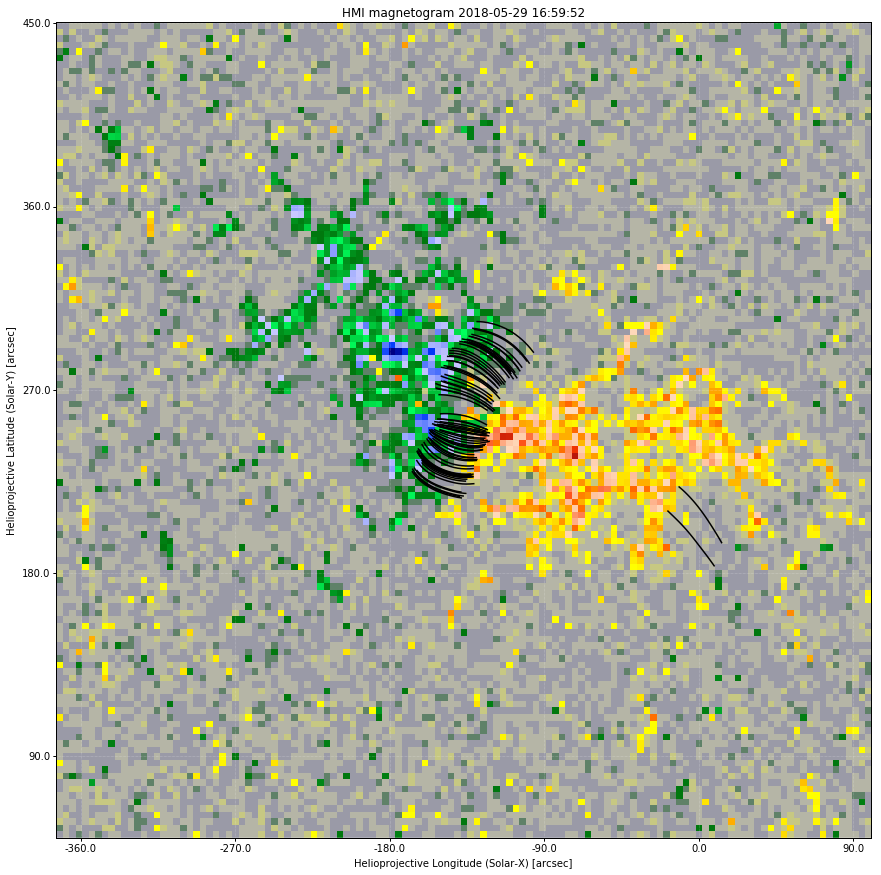

In [89]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection=active_region.magnetogram)
active_region.magnetogram.plot(cmap='hmimag',vmin=-1.5e3,vmax=1.5e3)
for l in active_region.loops:
    if l.full_length < 20*u.Mm:
        c_tran = l.coordinates.transform_to('heliographic_stonyhurst').transform_to(active_region.magnetogram.coordinate_frame)
        ax.plot_coord(c_tran,color='k')

## Computing Intensities
Ultimately, we want to compute the intensity as a function $\theta_x,\theta_y$ and time for the whole AR. We can do this most easily by computing the 171 intensity for each loop at each time and space coordinate, and then constructing a histogram of loop coordinates (in HPC), weighted by the intensity values, at each timestep. 

## Sandbox

In [2]:
s = Strand('/storage-home/w/wtb2/data/hi_c_simulation/hydrodynamics/loop000200/')

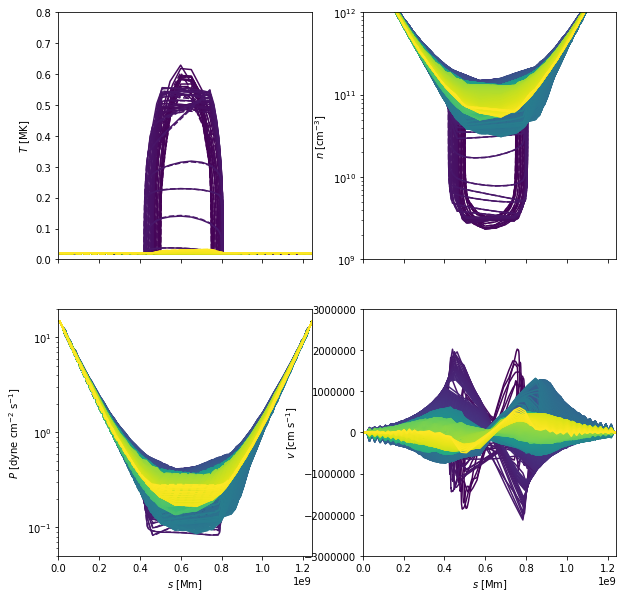

In [7]:
plot_strand(s,start=0,stop=1000,step=2,limits={'velocity':(-3e6,3e6),'temperature':(0,0.8),
                                                'density':(1e9,1e12),'pressure':(0.05,20)})

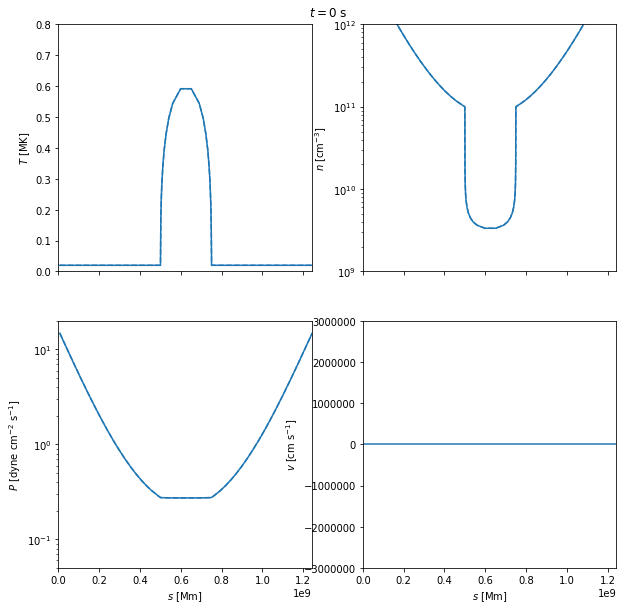

In [8]:
anim = animate_strand(s,start=0,stop=1000,step=2,limits={'velocity':(-3e6,3e6),'temperature':(0,0.8),
                                                         'density':(1e9,1e12),'pressure':(0.05,20)}, interval=20)

In [10]:
HTML(anim.to_html5_video())

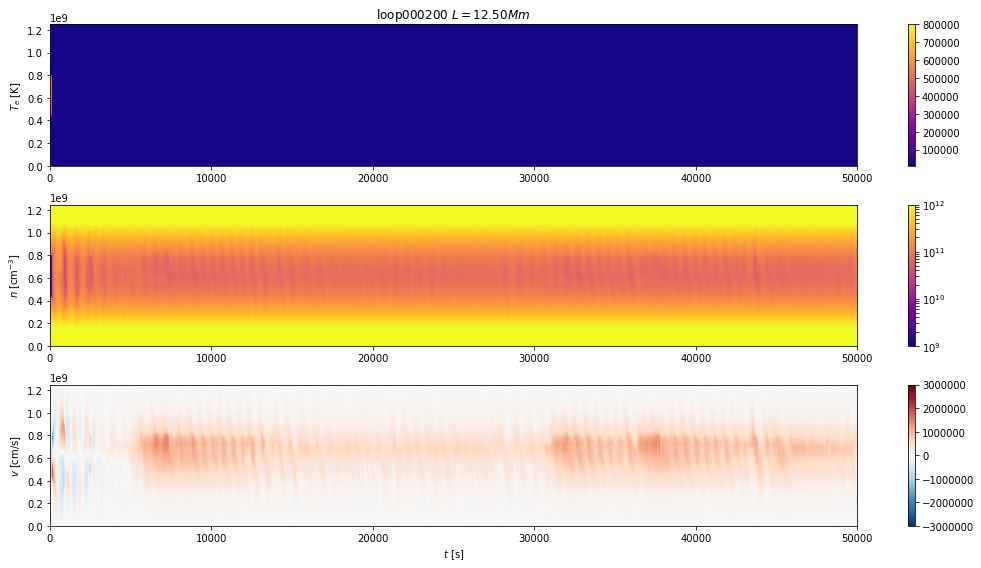

In [20]:
i_start = 0
i_finish = 10001
i_step = 2
l = active_region.loops[200]
with h5py.File(parameter_savefile.format(l.name),'r') as hf:
    s = u.Quantity(hf['coordinate'],hf['coordinate'].attrs['unit'])
    t = u.Quantity(hf['time'][i_start:i_finish:i_step],hf['time'].attrs['unit'])
    Te = u.Quantity(hf['electron_temperature'][:,i_start:i_finish:i_step],
                    hf['electron_temperature'].attrs['unit'])
    n = u.Quantity(hf['density'][:,i_start:i_finish:i_step],hf['density'].attrs['unit'])
    v = u.Quantity(hf['velocity'][:,i_start:i_finish:i_step],hf['velocity'].attrs['unit'])
# Create grids
grid_s,grid_t = np.meshgrid(t.value,s.value)
# Create plots
# Electron temperature
fig = plt.figure(figsize=(15,8),)
ax = fig.add_subplot(3,1,1)
ax.set_ylabel(r'$T_e$ [K]')
ax.set_title(f'{l.name} $L={l.full_length.to(u.Mm):.2f}$')
im = ax.pcolormesh(grid_s, grid_t, Te,cmap='plasma',vmin=1e4,vmax=8e5)
im.set_rasterized(True)
fig.colorbar(im,ax=ax)
## Density
ax = fig.add_subplot(3,1,2)
ax.set_ylabel(r'$n$ [cm$^{-3}$]')
im = ax.pcolormesh(grid_s, grid_t, n,cmap='plasma',norm=matplotlib.colors.LogNorm(vmin=1e9,vmax=1e12),)
im.set_rasterized(True)
fig.colorbar(im,ax=ax)
## Velocity
ax = fig.add_subplot(3,1,3)
ax.set_ylabel(r'$v$ [cm/s]')
ax.set_xlabel(r'$t$ [s]')
im = ax.pcolormesh(grid_s, grid_t, v,cmap='RdBu_r',vmin=-3e6,vmax=3e6,)
im.set_rasterized(True)
fig.colorbar(im,ax=ax)
plt.tight_layout()

In [26]:
short_loops = []
for l in active_region.loops:
    if l.full_length < 20*u.Mm:
        short_loops.append(l)

In [27]:
len(short_loops)

76